### This notebook will walk you through how to build a lipid bilayer with OpenFF

In [1]:
# Import all dependencies 

# from io import StringIO
# from typing import Iterable
import numpy as np
# import matplotlib.pyplot as plt

# from rdkit import Chem
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
# from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper

from openff.units import Quantity, unit
# from openmm import unit as openmm_unit
from openff.interchange import Interchange
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper #assign charges with NAGL

import nglview
import mdtraj
import sys
import os
import shutil
from pathlib import Path

scripts_path = os.path.join(os.getcwd(), 'scripts')
sys.path.insert(0, scripts_path)

from postPull import pull_new_lipid
import BuildLipid
from saveLipids import saveInterchange, Lipid, calcLipidLength, saveLipidCsv
from packmol import _build_input_file, runPackmol

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages
  warnings.warn(


In [2]:
from openff.nagl_models import list_available_nagl_models

list_available_nagl_models()

[PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.0.1-alpha.1.pt'),
 PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.1.pt'),
 PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.2.pt'),
 PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.3.pt')]

Available lipids are located in BuildLipid module, which constructs lipids in a modular fashion {sn1} + {hg} + {sn2}.
load_dataframe() to load in lipid library
list_available_lipids() will return a list of available headgroups, tailgroups, and sterols

In [3]:
# load in openFF's library of lipids and return a list of availablee lipid headgroups,tailgroups, and sterols to choose from
df = BuildLipid.load_dataframe()
BuildLipid.list_available_lipids(df) 

Available headgroups:  ['PA', 'PC', 'PE', 'PG', 'PP', 'PS']
Available tailgroups:  ['DC', 'DD', 'DL', 'DM', 'DO', 'DP', 'DR', 'DS', 'PE', 'PL', 'PO', 'PS', 'SL', 'SO']
Available sterols:  ['aldosterone', 'beta-Sitosterol', 'beta-estradiol', 'cholesterol', 'corticosterone', 'cortisol', 'ergosterol', 'estradiol', 'progesterone', 'stigmasterol', 'testosterone']


In [ ]:
POPC,,N1x,C42x,,7.0,53.0,30.51595776024497,O([P@@]([O-])(OCC[N+](C)(C)C)(=O))C[C@H](COC(=O)CCCCCCCCCCCCCCC)(OC(=O)CCCCCCC\C=C/CCCCCCCC)
cholesterol,,O1x,C7x,,32.0,8.0,17.82112264468474,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C
MC3,,N1x,C37x,,44.0,37.0,28.884357965081552,CCCCC\C=C/C\C=C/CCCCCCCCC(CCCCCCCC\C=C/C\C=C/CCCCC)OC(=O)CCCN(C)C 
SM102,,O1x,C44x,,1.0,49.0,24.931139421984337,OCC[N@](CCCCCCCC(OC(CCCCCCCC)CCCCCCCC)=O)CCCCCC(OCCCCCCCCCCC)=O
ALC0315,,O1x,C48x,,1.0,55.0,24.496943046528976,OCCCC[N@](CCCCCCOC([C@H](CCCCCC)CCCCCCCC)=O)CCCCCCOC([C@H](CCCCCC)CCCCCCCC)=O

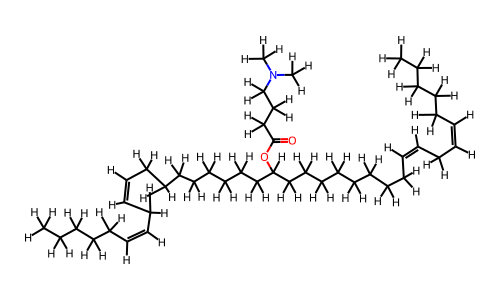

In [37]:
# Specify lipid you would like to parameterize "headgroup+tailgroup" or "sterol" (ex. 'POPC' or 'cholesterol') from the library of lipids
Lipid_name = 'cholesterol'
lipid_smiles, HG_pull_atom = BuildLipid.makeLipidSmiles(Lipid_name, df)


# if you want a lipid that is not yet supplied by the library, uncomment the 3 lines below and replace smiles string with your desired lipid,
# the pull atom with an atom in the headgroup, and the Lipid name with the common name or the lipid

lipid_smiles = 'CCCCC\C=C/C\C=C/CCCCCCCCC(CCCCCCCC\C=C/C\C=C/CCCCC)OC(=O)CCCN(C)C'
HG_pull_atom = 'N1x' #note that atom naming is openff format: atom type + atom number + x
Lipid_name = 'MC3'


lipid = Molecule.from_smiles(lipid_smiles,allow_undefined_stereo=True)
lipid.generate_conformers()
lipid.visualize()


#note that when making PEG lipids, ("CCCCCCCCCCCCCC(O[C@@H](COC(NCCC{Q}OC)=O)COC(CCCCCCCCCCCCC)=O)=O",True, replacements = {'{Q}':'OCC'*45})


In [31]:
lipid_smiles

'C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C'

In [38]:
#parameterize lipid with openff interchange

# Assign partial charges via OpenFF NAGL
lipid.assign_partial_charges("openff-gnn-am1bcc-0.1.0-rc.3.pt", toolkit_registry=NAGLToolkitWrapper())
lipid.partial_charges


lipid.name = Lipid_name
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = Lipid_name
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

# Specify forcefield
forcefield = ForceField("openff-2.2.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
interchange  

interchange.to_top(f"{Lipid_name}.top") #, decimal = 3, hydrogen_mass = 3) #for hygrogen mass repartitioning.. probably need another topology file filder for HMR
# or is there from grompp option to change topology file that can be used downstream?
interchange.to_gro(f"{Lipid_name}.gro")

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


In [ ]:
#build a water model and parameterize with openff interchange

water_model = 'TIP3P'
water = Molecule.from_smiles('O')
water.generate_conformers()
water.name = water_model

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = water_model
water.generate_unique_atom_names() 
topology = Topology.from_molecules([water])


interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
)
interchange

# PDB structure for Packmol
interchange.to_pdb(f"{water_model}.pdb")
interchange.to_top(f"{water_model}.top")

In [39]:
# the lipid is not in an optimal packing configuration, run code to "straighten out" lipid

pull_new_lipid(f'{Lipid_name}', HG_pull_atom)

                     :-) GROMACS - gmx make_ndx, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx make_ndx -f MC3.gro -o N1x.ndx


Reading structure file

GROMACS reminds you: "I tend to consider myself as a scientist." (Emmanuelle Charpentier, when asked about the importance of two women sharing the Nobel Prize for Chemistry)

                      :-) GROMACS - gmx grompp, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx grompp -f scripts/runPull.mdp -c MC3.gro -p MC3.top -n N1x.ndx -o pull.tpr -maxwarn 2

Generating 1-4 interactions: fudge = 0.5
Pull group 1 'pull_atom' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 293.00

NOTE 1 [file scripts/runPull.mdp]:
  

Going to read 0 old index file(s)
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              :   125 atoms
  1 Other               :   125 atoms
  2 MC3                 :   125 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 1 atoms with name N1X

> 

> 
Setting the LD random seed to 1045348323

Generated 7875 of the 7875 non-bonded parameter combinations

Generated 7875 of the 7875 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'MC3'

turning H bonds into constraints...

Setting gen_seed to -7130563

starting mdrun 'FOO'
25000 steps,     50.0 ps.


Note that major changes are planned in future for editconf, to improve usability and utility.
Read 125 atoms
Volume: 125 nm^3, corresponds to roughly 56200 electrons
Velocities found



Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      274.540       17.159     1599.9
                 (ns/day)    (hour/ns)
Performance:      251.767        0.095

GROMACS reminds you: "A method is more important than a discovery, since the right method will lead to new and even more important discoveries." (Lev Landau)

                     :-) GROMACS - gmx editconf, 2023.1 (-:

Executable:   /home/julianne/pkgs/gromacs-2023.1/bin/gmx
Data prefix:  /home/julianne/pkgs/gromacs-2023.1
Working dir:  /media/julianne/DATA/Lipids/OpenFFLipid/Workflow
Command line:
  gmx editconf -f pull.gro -o MC3.pdb


Back Off! I just backed up MC3.pdb to ./#MC3.pdb.1#

GROMACS reminds you: "A method is more important than a discovery, since the right method will lead to new and even more important discoveries." (Lev Landau)



In [40]:
# save the pulled lipid pdb to folder, creates a folder for specific lipid if it doesnt already exist

file_paths = [f'{Lipid_name}.pdb', f'{Lipid_name}.top'] 
saveInterchange(Lipid_name, file_paths)

# once we have a large enough library of pulled lipids, we will no longer have to run pulling commmands for each lipid

MC3.pdb saved to /media/julianne/DATA/Lipids/OpenFFLipid/Workflow/Dictionary/lipids_parameterized/MC3/MC3.pdb
MC3.top saved to /media/julianne/DATA/Lipids/OpenFFLipid/Workflow/Dictionary/lipids_parameterized/MC3/MC3.top


### Use trjconv to produce a pdb of the lipid after pull code. Visualize with nglview to confirm 


In [9]:
#visualize the pulled lipid using ngl view
view = nglview.show_structure_file(f'Dictionary/lipids_parameterized/{Lipid_name}/{Lipid_name}.pdb')
view


NGLWidget()

In [41]:
# save the pulled lipid data to a csv. YOU WILL NEED TO MANUALLY FIND A TERMINAL ATOM IN THE LIPID TAIL (last carbon in sn1 or sn2)
lipid = Lipid(
    name=Lipid_name,
    headgroup_atom=HG_pull_atom,  
    headgroup_atom_index=None, 
    tailgroup_atom='C37x',  # this needs to be changed for every simulation
    tailgroup_atom_index=None,
    distance=None,  
    experimental_density=None,  # Example value in g/cm^3, not necessary but may be helpful in the future?
    smiles_string = lipid_smiles
)

# Calculate lipid length (distance between headgroup and tailgroup)
calcLipidLength(lipid, Lipid_name)

# # Save the lipid to the CSV file with all its corresponding information
# saveLipidCsv(lipid)

/media/julianne/DATA/Lipids/OpenFFLipid/Workflow/Dictionary/lipids_parameterized/MC3/MC3.pdb


/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [42]:
# Save the lipid to the CSV file with all its corresponding information
saveLipidCsv(lipid)

Lipid 'MC3' saved to CSV location: Dictionary/PulledLipid.csv.
